## 此專案用於開發 RUL 預測程式的最終版本, 此處先以單點分析再推廣至多工況 ##



### 導入模型設定與套件 ###

In [93]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose, Concatenate,LSTM
from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train



GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 建立 LSTM 預測模型架構 ##
I2 in I2 out

### 確立訓練工況檔案來源 ###
使用 CCAE 範本作為正常工況

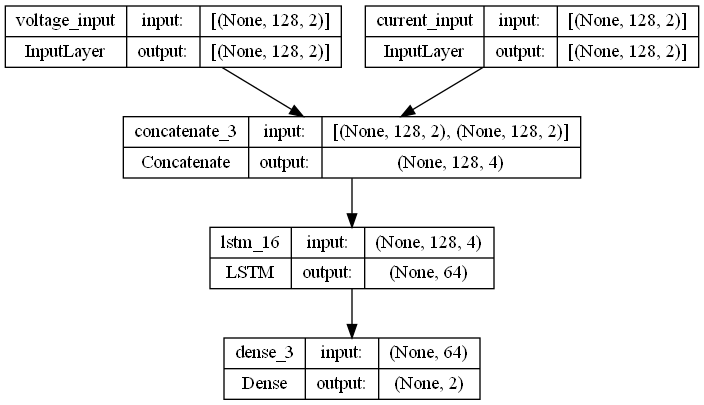

In [94]:
from datetime import datetime
import json
from tensorflow.keras.optimizers import Adam

# Initial model parameters
sequence_length=128
layer_number=1

model_folder_path = r'NTU_rul_models\time_series_models'
model_name = f'CCAE_iterative_lstm_SigleLayer{layer_number}Base{sequence_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

def build_iterative_lstm_model(seq_len=128, x_dim=2, y_dim=2, lstm_units=64):
    # Input: [電壓 x] 和 [電流 y] 序列
    x_input = Input(shape=(seq_len, x_dim), name='voltage_input')
    y_input = Input(shape=(seq_len, y_dim), name='current_input')

    # Concatenate voltage and current along feature dimension
    merged = Concatenate(axis=-1)([x_input, y_input])  # shape: (128, 4)

    # LSTM block
    lstm_out = LSTM(lstm_units, return_sequences=False)(merged)  # 最後時間步的隱向量

    # Output next-step current (2D)
    output = Dense(y_dim)(lstm_out)
    
    model=Model(inputs=[x_input, y_input], outputs=output)

    return model


# build model 
my_model = build_iterative_lstm_model(seq_len=sequence_length, x_dim=2, y_dim=2, lstm_units=64)
my_model.compile(optimizer='adam', loss='mse')
metadata = {
    "model_name": model_name,
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

        
        
plot_model(my_model, to_file=os.path.join(model_path, model_name+'.png'), show_shapes=True, show_layer_names=True)


In [95]:

from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
import random

np.random.seed(42)
random.seed(42)

# Data set folder 
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets'
Normal_data_path = os.path.join(NTU_dataset_path, 'Normal2')


def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+1  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data


# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]

selected_folder=["1800_0_5V","1800_1_0V", "1800_2_0V"]  # 選擇特定資料夾
# 選擇與 selected_folder 名稱符合的特定資料夾
Normal_subfolders = [folder for folder in Normal_subfolders if any(sel in folder for sel in selected_folder)]

# 分割內部測試與訓練集
train_files = []
val_files = []
for folder in Normal_subfolders:
    parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
    # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
    
    if len(parquet_files) > 1:
        train, val = train_test_split(parquet_files, test_size=0.2)
       
        train_files.extend(train)
        val_files.extend(val)
    elif len(parquet_files) == 1:
        train_files.extend(parquet_files)

train_signals=[]

for file_path in train_files:
    if os.path.exists(file_path):
        
        # read the data
        df = read_rul_data(file_path)
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        
        temp_train_signals=[np.array(df["Voltage alpha downsample"]), 
                                  np.array(df["Voltage beta downsample"]),
                                  np.array(df["Current alpha downsample"]),
                                  np.array(df["Current beta downsample"])] 
        
        temp_train_signals = np.stack(temp_train_signals, axis=1)
        
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=1000)
        # 加入 train_input_signals
        train_signals.append(temp_train_input_signals_augmented)
        
    else:
        print(f"File {file_path} does not exist.")
        

train_signals = np.concatenate(train_signals,axis=0).astype(np.float32)
train_input_signals=train_signals[:, :-1, :]  # 去掉最後一個時間步長
train_fit_signals = train_input_signals[:, -1, :]  # 取最後一個時間步長

print(f"Train input signals shape: {train_input_signals[:,:,0:2].shape}")
print(f"Train fit signals shape: {train_fit_signals.shape}")

    

Train input signals shape: (45000, 128, 2)
Train fit signals shape: (45000, 4)


### 模型訓練 ###

Epoch 1/20
633/633 [==============================] - 6s 9ms/step - loss: 0.0080 - val_loss: 8.8023e-04
Epoch 2/20
633/633 [==============================] - 5s 8ms/step - loss: 6.3967e-04 - val_loss: 5.8938e-04
Epoch 3/20
633/633 [==============================] - 5s 7ms/step - loss: 5.2305e-04 - val_loss: 6.0558e-04
Epoch 4/20
633/633 [==============================] - 5s 7ms/step - loss: 4.6101e-04 - val_loss: 4.3153e-04
Epoch 5/20
633/633 [==============================] - 5s 7ms/step - loss: 3.9853e-04 - val_loss: 4.1731e-04
Epoch 6/20
633/633 [==============================] - 5s 8ms/step - loss: 3.4181e-04 - val_loss: 4.4000e-04
Epoch 7/20
633/633 [==============================] - 6s 9ms/step - loss: 3.1114e-04 - val_loss: 4.0539e-04
Epoch 8/20
633/633 [==============================] - 5s 8ms/step - loss: 2.5273e-04 - val_loss: 3.0207e-04
Epoch 9/20
633/633 [==============================] - 5s 8ms/step - loss: 2.1980e-04 - val_loss: 2.2501e-04
Epoch 10/20
633/633 [===========

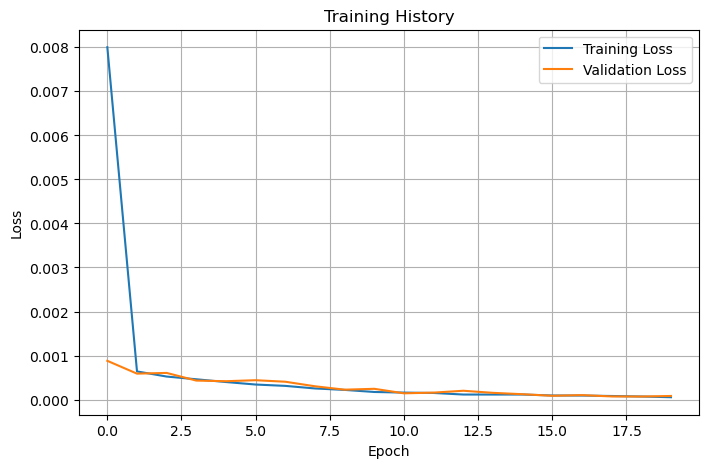

In [96]:
history = my_model.fit([train_input_signals[:,:,0:2], train_input_signals[:,:,2:4]], train_fit_signals[:,2:4], epochs=20, batch_size=64, validation_split=0.1)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

### 驗證結果 ###

In [110]:
import tensorflow as tf

@tf.function
def fast_iterative_forecast(model, init_voltage, init_current, future_voltage_seq):
    """
    init_voltage: (128, 2)  float32
    init_current: (128, 2)  float32
    future_voltage_seq: (n, 2) float32
    return: (n, 2) predicted current
    """

    n = tf.shape(future_voltage_seq)[0]
    hist_x = tf.TensorArray(dtype=tf.float32, size=129, dynamic_size=True)
    hist_y = tf.TensorArray(dtype=tf.float32, size=129, dynamic_size=True)

    hist_x = hist_x.scatter(tf.range(0, 128), init_voltage)
    hist_y = hist_y.scatter(tf.range(0, 128), init_current)

    output_y = tf.TensorArray(dtype=tf.float32, size=n)

    def condition(i, *_):
        return i < n

    def body(i, hist_x, hist_y, output_y):
        input_x = hist_x.gather(tf.range(i, i + 128))
        input_y = hist_y.gather(tf.range(i, i + 128))

        # predict next y
        pred = model([tf.expand_dims(input_x, 0), tf.expand_dims(input_y, 0)], training=False)[0]

        output_y = output_y.write(i, pred)

        # 更新歷史 x, y
        hist_x = hist_x.write(i + 128, future_voltage_seq[i])
        hist_y = hist_y.write(i + 128, pred)

        return i + 1, hist_x, hist_y, output_y

    i0 = tf.constant(0)
    _, _, _, output_y = tf.while_loop(
        cond=condition,
        body=body,
        loop_vars=[i0, hist_x, hist_y, output_y],
        parallel_iterations=1
    )

    return output_y.stack()


def iterative_forecast(model, voltage_seq, current_seq, future_voltage_seq):
    """
    voltage_seq: shape (128, 2)  # 歷史電壓
    current_seq: shape (128, 2)  # 歷史電流
    future_voltage_seq: shape (n, 2)  # 未來電壓序列
    return: predicted_currents: shape (n, 2)
    """
    history_x = voltage_seq.copy()
    history_y = current_seq.copy()

    predicted_currents = []

    for i in range(len(future_voltage_seq)):
        # 預測下一步電流 (加入batch 維度)
        y_pred = model.predict(
            [history_x[np.newaxis], history_y[np.newaxis]], verbose=0
        )[0]  # shape: (2,)

        # 更新輸入序列
        history_x = np.vstack([history_x[1:], future_voltage_seq[i:i+1]])
        history_y = np.vstack([history_y[1:], y_pred[np.newaxis]])
        
        predicted_currents.append(y_pred)
        
        # print(f"step predicted: {i}")

    return np.array(predicted_currents)

test_data=read_rul_data(val_files[0])
predict_length=512

x_128= np.array([test_data["Voltage alpha downsample"][0:sequence_length], 
                            test_data["Voltage beta downsample"][0:sequence_length]]).T
y_128 = np.array([test_data["Current alpha downsample"][0:sequence_length], 
                            test_data["Current beta downsample"][0:sequence_length]]).T
x_future = np.array([test_data["Voltage alpha downsample"][sequence_length:sequence_length+predict_length], 
                            test_data["Voltage beta downsample"][sequence_length:sequence_length+predict_length]]).T
print(x_128.shape)
print(y_128.shape)
print(x_future.shape)
y_future_pred = fast_iterative_forecast(my_model, x_128.astype(np.float32), y_128.astype(np.float32), x_future.astype(np.float32))



(128, 2)
(128, 2)
(512, 2)


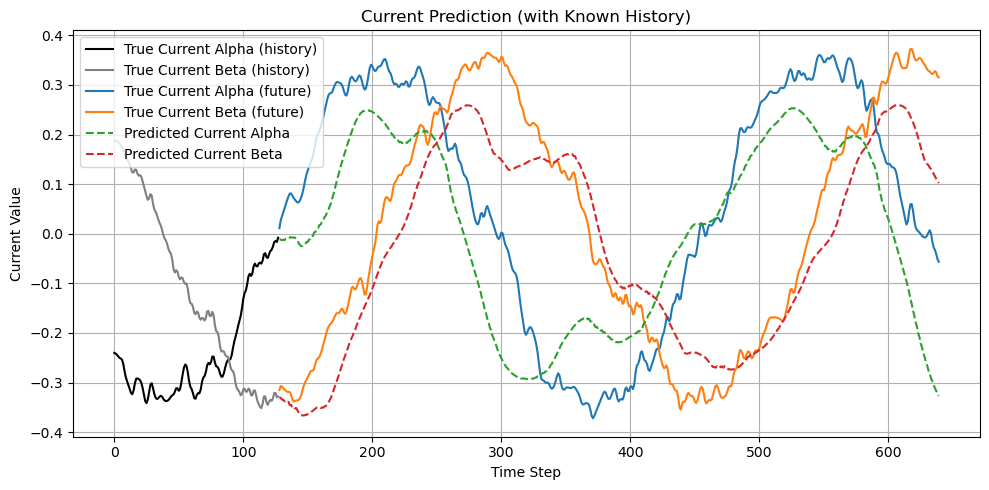

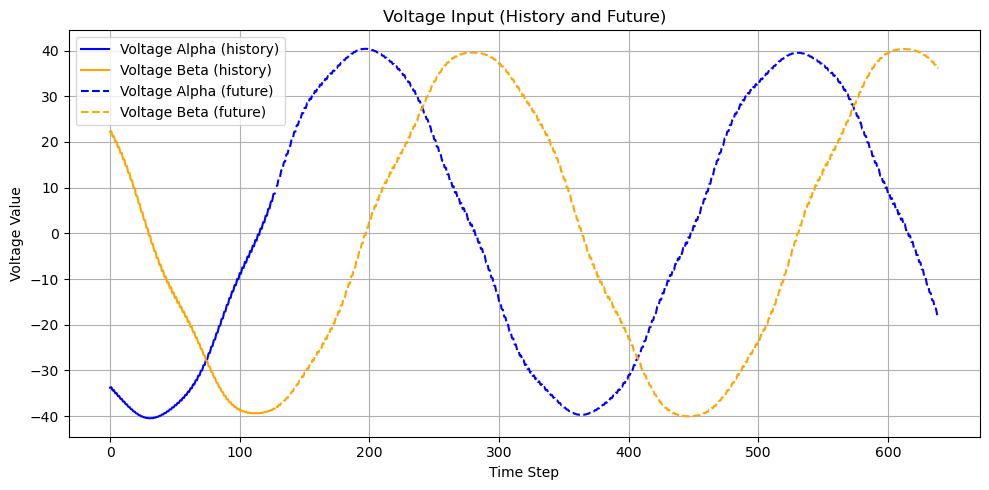

In [112]:
plt.figure(figsize=(10, 5))
true_future_current = np.array([
    test_data["Current alpha downsample"][sequence_length:sequence_length+predict_length],
    test_data["Current beta downsample"][sequence_length:sequence_length+predict_length]
]).T
# 已知資料（前128點）
plt.plot(range(sequence_length), y_128[:, 0], color='black', label='True Current Alpha (history)')
plt.plot(range(sequence_length), y_128[:, 1], color='gray', label='True Current Beta (history)')

# 未來預測部分（128點）
plt.plot(range(sequence_length, sequence_length+predict_length), true_future_current[:, 0], color='tab:blue', label='True Current Alpha (future)')
plt.plot(range(sequence_length, sequence_length+predict_length), true_future_current[:, 1], color='tab:orange', label='True Current Beta (future)')
plt.plot(range(sequence_length, sequence_length+predict_length), y_future_pred[:predict_length, 0].numpy(), color='tab:green', linestyle='--', label='Predicted Current Alpha')
plt.plot(range(sequence_length, sequence_length+predict_length), y_future_pred[:predict_length, 1].numpy(), color='tab:red', linestyle='--', label='Predicted Current Beta')

plt.title('Current Prediction (with Known History)')
plt.xlabel('Time Step')
plt.ylabel('Current Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
# 已知電壓（前128點）
plt.plot(range(sequence_length), x_128[:, 0], color='blue', label='Voltage Alpha (history)')
plt.plot(range(sequence_length), x_128[:, 1], color='orange', label='Voltage Beta (history)')
# 未來電壓（預測區間）
plt.plot(range(sequence_length, sequence_length+predict_length), x_future[:predict_length, 0], color='blue', linestyle='--', label='Voltage Alpha (future)')
plt.plot(range(sequence_length, sequence_length+predict_length), x_future[:predict_length, 1], color='orange', linestyle='--', label='Voltage Beta (future)')
plt.title('Voltage Input (History and Future)')
plt.xlabel('Time Step')
plt.ylabel('Voltage Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [ ]:

from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
import random


# Data set folder 
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets'
Normal_data_path = os.path.join(NTU_dataset_path, 'Normal2')
# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]

exclude_condition="1800_1_0V"  # 排除特定資料夾
Normal_subfolders = [folder for folder in Normal_subfolders if exclude_condition not in folder]

# 分割 20% 資料作為驗證集 80% 資料作為訓練集
train_files = []
val_files = []

for folder in Normal_subfolders:
    parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
    # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
    if len(parquet_files) > 1:
        train, val = train_test_split(parquet_files, test_size=0.2, random_state=42)
        train_files.extend(train)
        val_files.extend(val)
    elif len(parquet_files) == 1:
        train_files.extend(parquet_files)

# 打亂訓練資料順序，避免batch 中資料條件分布影響訓練結果
random.seed(42)
random.shuffle(train_files)
random.shuffle(val_files)
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")


from time import time
train_input_signals=[]
torque_conditions=[]
speed_conditions=[]

temp_torque=[]
temp_speed=[]
for file_path in train_files:
    if os.path.exists(file_path):
        
        # read the data
        df = read_rul_data(file_path)
        
        rms = np.sqrt(np.mean(np.square(df["Current alpha downsample"])))
        if rms<0.1:
            print(f"File {file_path} has abnormal RMS current, skipping.")
            continue
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_input_signals = []
        for input_name in network_input_signal_names:
        # normalization
            raw_data=np.array(df[input_name])  
            normalized = raw_data / network_normalization_rate[input_name]  # 標準化
            basic_signal,_=filter_top_n_frequencies(normalized, 1)
            residual_signal = normalized - basic_signal
            normalized_residual_signal = (residual_signal - np.mean(residual_signal)) / np.std(residual_signal)
            augmented_data= data_augmentation(normalized_residual_signal, time_steps=sequence_length, window_size=10, cols=[0], random_seed=42)
            temp_train_input_signals.append(augmented_data) # normalization
            
            # 先做資料增強轉換至 (N*[(L-W)/1024+1], 1024, dim 維度)
            
        # 加入 train_input_signals
        train_input_signals.append(np.stack(temp_train_input_signals, axis=2))
        
        # 將條件擴展為 (temp_train_input_signals[0].shape[0], 1)
        torque_value_pu = np.array(df["Torque avg"]).reshape(-1)/ rated_torque
        speed_value_pu = np.array(df["Speed"]).reshape(-1) / rated_speed
        temp_torque.append(torque_value_pu[0])
        temp_speed.append(speed_value_pu[0])
        torque_expanded = np.full(temp_train_input_signals[0].shape[0], torque_value_pu[0])
        speed_expanded = np.full(temp_train_input_signals[0].shape[0], speed_value_pu[0])
        torque_conditions.append(torque_expanded)
        speed_conditions.append(speed_expanded)
        
    else:
        print(f"File {file_path} does not exist.")
        
train_input_signals = np.concatenate(train_input_signals,axis=0).astype(np.float32)
torque_conditions = np.concatenate(torque_conditions, axis=0).astype(np.float32)
speed_conditions = np.concatenate(speed_conditions, axis=0).astype(np.float32)

print(f"Train input signals shape: {train_input_signals.shape}")

Train files: 120
Validation files: 32
Train input signals shape: (71520, 2048, 2)


In [ ]:
model_metadata["train_date"]

'2025-06-23 12:21:34'

** Step 2: train the ccae model **

取前10% 的資料作為訓練數據

In [ ]:

from test_algs.CCAE_ntu_rul import data_augmentation
# use the first 10% data for CCAE training or filtering 

train_factor=0.1  # 訓練資料比例(前10%資料)
initial_files = []
initial_datalist=[]
train_input_signals=[]
train_output_signals=[]

for file_path in train_file_list:
    if os.path.exists(file_path):

        # load and sort the files in path 
        files = [os.path.join(file_path, f) for f in os.listdir(file_path) if f.endswith(".parquet")] 
        files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))
        
        # Use only first 10% of files for training 
        num_files = max(int(len(files) * train_factor),1)
        
        #對每個測試資料夾取出訓練資料
        for i in range(num_files):
            # read the data
            df = read_rul_data(files[i])
            if len(df[network_input_signal_names[0]])<2000:
                print('incorrect data length, please check the file: \n', files[i])
                print('raw data length: ', len(df["Voltage alpha"]))
                continue
            # 合併測試資料至訓練維度 shape=(,4000,dim)
            temp_train_input_signals = []
            for input_name in network_input_signal_names:
            # normalization
                raw_data=np.array(df[input_name])
                mean = np.mean(raw_data)
                standard = np.std(raw_data)
                normalized = (raw_data - mean) / standard  # 轉成 (1024, 1)
                augmented_data= data_augmentation(normalized, time_steps=1024, window_size=10, cols=[0], random_seed=42)
                temp_train_input_signals.append(augmented_data) # normalization
                
                # 先做資料增強轉換至 (N*[(L-W)/1024+1], 1024, dim 維度)
                
            # 加入 train_input_s
            # ignals
            train_input_signals.append(np.stack(temp_train_input_signals, axis=2))            
    else:
        print(f"File {file_path} does not exist.")
# 將所有訓練資料合併成一個大矩陣 (N_total, 1024, dim)
train_input_signals = np.concatenate(train_input_signals,axis=0)
print(f"train_input_signals shape: {train_input_signals.shape}")
        

train_input_signals shape: (93196, 1024, 4)


# 訓練模型 #

Model CCAE_V2_in_I2_out.keras exists, loading the model.
Model CCAE_V2_in_I2_out.keras loaded successfully.
Model CCAE_V2_in_I2_out.keras has not been trained yet, proceeding with training.
Epoch 1/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - Decoder_loss: 0.1318 - loss: 0.2592 - val_Decoder_loss: 0.0173 - val_loss: 0.0322
Epoch 2/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - Decoder_loss: 0.0166 - loss: 0.0313 - val_Decoder_loss: 0.0152 - val_loss: 0.0284
Epoch 3/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - Decoder_loss: 0.0150 - loss: 0.0282 - val_Decoder_loss: 0.0137 - val_loss: 0.0259
Epoch 4/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - Decoder_loss: 0.0134 - loss: 0.0253 - val_Decoder_loss: 0.0132 - val_loss: 0.0252
Epoch 5/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - Decoder_loss: 0.0125 - loss: 0.0237 - val_Decoder_loss: 0.0126 - val_loss: 0.0243
Epoch 6/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - Decoder_loss: 0.0119 - loss: 0.0226 - val_Decoder_loss: 0.0118 -

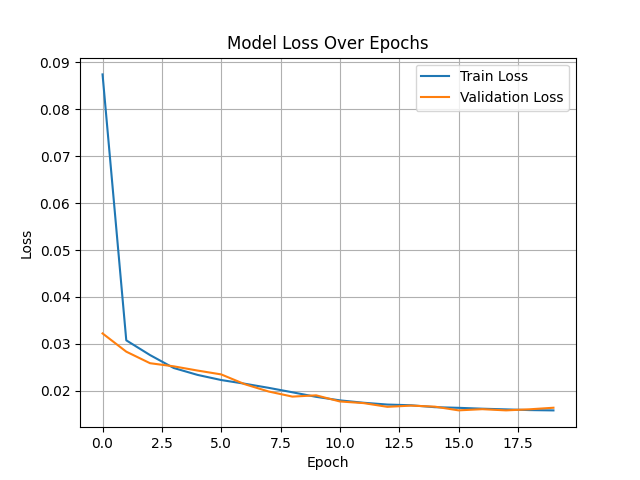

In [ ]:

# from test_algs.CCAE_ntu_rul import CCAE_train

if os.path.exists(os.path.join(model_folder_path, "models", model_name)):
    
    # 如果模型已存在，則載入模型
    print(f"Model {model_name} exists, loading the model.")
    my_ccae_model_trained = load_model(os.path.join(model_folder_path, "models", model_name), compile=False)
    print(f"Model {model_name} loaded successfully.")
    
    # 讀取模型的 json metadata
    metadata_path = os.path.join(model_folder_path, "model_inform", model_name.replace('.keras', '_metadata.json'))
    with open(metadata_path, "r", encoding="utf-8") as f:
        model_metadata = json.load(f)
    
    #若非則重新訓練模型
    # --------------------模型訓練---------------------
    if  (not model_metadata.get("trained", False)) or model_retraining:
        print(f"Model {model_name} has not been trained yet, proceeding with training.")
       
        time_start = time.time()
        Labels = np.full(train_input_signals.shape[0], 1)
        epochs=20
        batch_size=100
        my_ccae_model1_trained, train_history=CCAE_model_build_train.CCAE_train(my_ccae_model_trained,model_type,os.path.join(model_folder_path,"models", model_name), 
                                                                                train_input_signals, label=1, 
                                                                                epochs=epochs, batch_size=batch_size)
        # 設定訓練屬性並儲存
        my_ccae_model_trained.save(os.path.join(model_folder_path, model_name))
        
        # 更新模型 metadata
        model_metadata["trained"] = True
        model_metadata["train_date"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        with open(os.path.join(model_folder_path,"model_inform", model_name.replace('.keras', '_metadata.json')), "w", encoding="utf-8") as f:
                json.dump(model_metadata, f, ensure_ascii=False, indent=4)

        print("Training complete, elpased time:", time.time() - time_start)

        # 繪製 Loss
        plt.figure()
        plt.plot(train_history.history['loss'], label='Train Loss')
        plt.plot(train_history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Model Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()
else :
    # 如果模型不存在，則拋出錯誤
    raise FileNotFoundError(f"Model {model_name} does not exist in {os.path.join(model_folder_path, 'models')}.")

In [ ]:
print( model_retraining )

True


# 檢視重建結果 #

In [ ]:
verify_results = my_ccae_model_trained.predict([train_input_signals[0:1,:,0:1], train_input_signals[0:1,:,1:2] , np.array([[1]]) ])
plt.figure()
plt.title('CCAE Reconstructed Signals')
plt.plot(train_input_signals[0,:,2], label='Input Alpha')
plt.plot(np.squeeze(np.array(verify_results[0])), label='Reconstructed Alpha')

NameError: name 'my_ccae_model_trained' is not defined

## 套用 CCAE 模型 ##

In [ ]:
# --------------------模型應用---------------------
# 合併所有檔案的數據增強輸入資料，一次套用模型，然後依據每個檔案的增強數量分割結果，計算每檔案的MSE

def apply_ccae_model_to_files_v2(rul_file_path, ccae_model, model_type, network_input_signal_names):
    """
    輸入:
        rul_file_path: str, RUL資料夾路徑
        ccae_model: keras model, 已訓練好的CCAE模型
        network_input_signal_names: name list, 模型輸入信號名稱
        model_type: str, 模型輸入輸出類型（例如 'V2_in_I2_out'）
    輸出:
        ccae_apply_result: dict, 包含每個檔案的MSE誤差和時間列表
    """
    files = [os.path.join(rul_file_path, f) for f in os.listdir(rul_file_path) if f.endswith(".parquet")]
    files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))

    all_augmented_inputs = []
    file_aug_counts = []
    file_raw_data = []

    # 先收集所有檔案的增強輸入
    for file in files:
        temp_train_input_signals = []
        df = read_rul_data(file)
        file_raw_data.append(df)
        for input_name in network_input_signal_names:
            raw_data = np.array(df[input_name])
            mean = np.mean(raw_data)
            standard = np.std(raw_data)
            normalized = (raw_data - mean) / standard
            augmented = data_augmentation(normalized, time_steps=1024, window_size=10, cols=[0], random_seed=42)
            temp_train_input_signals.append(augmented)
        # shape: (aug_num, 1024, channel)
        model_input_signals = np.stack(temp_train_input_signals, axis=2)
        all_augmented_inputs.append(model_input_signals)
        file_aug_counts.append(model_input_signals.shape[0])

    # 合併所有檔案的增強輸入資料
    all_inputs = np.concatenate(all_augmented_inputs, axis=0)  # (N_total, 1024, channel)
    
    # 準備模型輸入，針對不同模型類型進行處理
    if model_type == 'I2_in_I2_out':
        all_model_inputs = all_inputs              # (N_total, 1024, 2)
        all_verify_data = all_model_inputs.copy()  # (N_total, 1024, 2)
    if model_type == 'V2_in_I2_out':
        # 只取前兩個通道(Valpha, Vbeta) 作為輸入, (Ialpha, Ibeta) 為重建目標
         all_model_inputs = all_inputs[:, :, :2]  # (N_total, 1024, 2)
         all_verify_data = all_inputs[:, :, 2:4]  # (N_total, 1024, 2)
    elif model_type == 'V2I2_in_V2I2_out':
        # 保留四個通道作為輸入
        all_model_inputs = all_inputs              # (N_total, 1024, 4)
        all_verify_data = all_model_inputs.copy()  # (N_total, 1024, 4)
    # 分解輸入訊號至多個單通道輸入       
    split_input_list = [all_model_inputs[:, :, i:i+1] for i in range(all_model_inputs.shape[2])]
    split_input_list.append(np.ones((all_model_inputs.shape[0], 1)))  # 條件輸入

    # 一次性模型推論
    results = ccae_model.predict(split_input_list)
    # results: list, 每個 output shape = (N_total, 1024, 1)

    # 依據每個檔案的增強數量分割結果，計算每檔案的MSE
    mse_errors_by_file = []
    start_idx = 0
    for file_idx, aug_num in enumerate(file_aug_counts):
        end_idx = start_idx + aug_num
        # 取出該檔案的輸入與重建結果
        input_this_file = all_verify_data[start_idx:end_idx]  # (aug_num, 1024, channel)
        recon_this_file = [r[start_idx:end_idx] for r in results]  # list of (aug_num, 1024, 1)
        recon_this_file = np.concatenate(recon_this_file, axis=2)  # (aug_num, 1024, channel)
        # 計算每個增強片段的MSE，然後平均
        mse = np.mean((input_this_file - recon_this_file) ** 2, axis=(1,2))  # (aug_num,)
        mse_avg = np.mean(mse)
        mse_errors_by_file.append(mse_avg)
        start_idx = end_idx

    ccae_apply_result = {
        "file_path": rul_file_path,
        "file_list": files,
        "augment_counts": file_aug_counts,
        "mse_avg_byfile": mse_errors_by_file,
        "network_input_signal_names": network_input_signal_names,
    }
    return ccae_apply_result,all_inputs, results

ccae_result, all_inputs, results = apply_ccae_model_to_files_v2(train_file_list[0], my_ccae_model1_trained, model_type, network_input_signal_names)


3269/3269 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


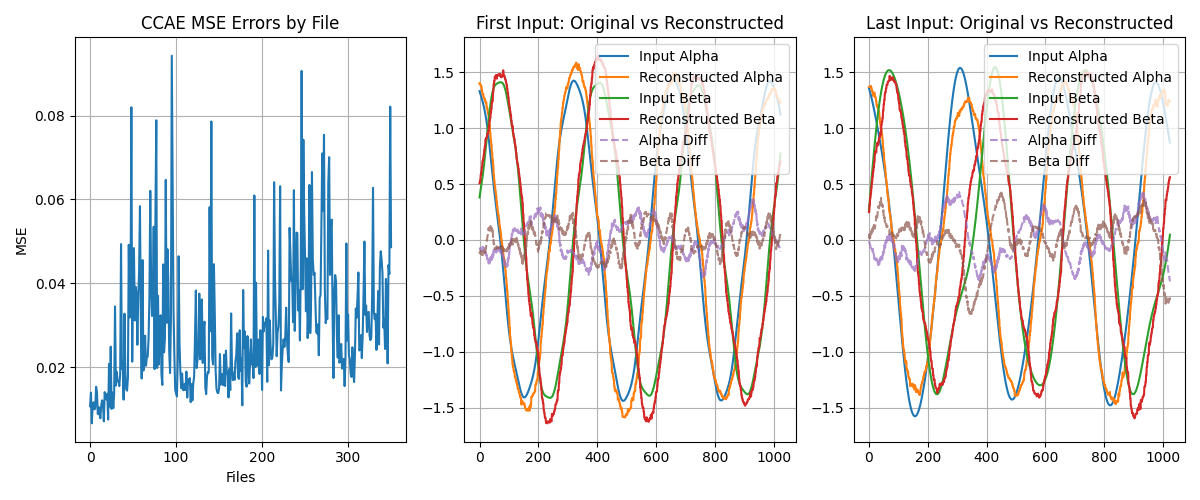

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# 1. MSE Errors by File
axs[0].plot(range(len(ccae_result['mse_avg_byfile'])), ccae_result['mse_avg_byfile'])
axs[0].set_title('CCAE MSE Errors by File')
axs[0].set_xlabel('Files')
axs[0].set_ylabel('MSE')
axs[0].grid(True)

# 2. First input: original vs reconstructed
first_input = all_inputs[0:1]
first_recon = my_ccae_model1_trained.predict([first_input[:, :, 0:1], first_input[:, :, 1:2], np.array([[1]])])
axs[1].plot(first_input[0, :, 0], label='Input Alpha')
axs[1].plot(np.squeeze(first_recon[0][0]), label='Reconstructed Alpha')
axs[1].plot(first_input[0, :, 1], label='Input Beta')
axs[1].plot(np.squeeze(first_recon[1][0]), label='Reconstructed Beta')
# 差異
axs[1].plot(first_input[0, :, 0] - np.squeeze(first_recon[0][0]), label='Alpha Diff', linestyle='--', alpha=0.7)
axs[1].plot(first_input[0, :, 1] - np.squeeze(first_recon[1][0]), label='Beta Diff', linestyle='--', alpha=0.7)
axs[1].set_title('First Input: Original vs Reconstructed')
axs[1].legend()
axs[1].grid(True)

# 3. Last input: original vs reconstructed
last_input = all_inputs[-1:]
last_recon = my_ccae_model1_trained.predict([last_input[:, :, 0:1], last_input[:, :, 1:2], np.array([[1]])])
axs[2].plot(last_input[0, :, 0], label='Input Alpha')
axs[2].plot(np.squeeze(last_recon[0][0]), label='Reconstructed Alpha')
axs[2].plot(last_input[0, :, 1], label='Input Beta')
axs[2].plot(np.squeeze(last_recon[1][0]), label='Reconstructed Beta')
# 差異
axs[2].plot(last_input[0, :, 0] - np.squeeze(last_recon[0][0]), label='Alpha Diff', linestyle='--', alpha=0.7)
axs[2].plot(last_input[0, :, 1] - np.squeeze(last_recon[1][0]), label='Beta Diff', linestyle='--', alpha=0.7)
axs[2].set_title('Last Input: Original vs Reconstructed')
axs[2].legend()
axs[2].grid(True)

# 統一第二、三張圖的 y 軸範圍
ymin = min(axs[1].get_ylim()[0], axs[2].get_ylim()[0])
ymax = max(axs[1].get_ylim()[1], axs[2].get_ylim()[1])
axs[1].set_ylim(ymin, ymax)
axs[2].set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [ ]:
print(model_input_signas)  # 檢查第一個檔案的結果形狀

NameError: name 'model_input_signas' is not defined

In [ ]:
# 根據 my_ccae_objects 的數量動態產生 (n, 1) 的 subplot
n = len(my_ccae_objects)
fig, axes = plt.subplots(n, 1, figsize=(12, 3 * n), sharex=True)

if n == 1:
    axes = [axes]  # 保證 axes 可迭代

for idx, (my_ccae, ax) in enumerate(zip(my_ccae_objects, axes)):
    ax.plot(my_ccae.basic_timelist["Time stamps"], my_ccae.ccae_repport["mse_avg_byfile"],
            label=f"File: {my_ccae.file_path.split(os.sep)[-1]}")
    ax.set_ylabel("MSE Error")
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0, 0.005)

axes[-1].set_xlabel("Sample Index")
plt.tight_layout()
plt.show()

In [ ]:

# 繪製並重疊每次實驗的 MSE Errors
plt.figure(figsize=(12, 8))
plt.xlabel("Sample Index")
plt.ylabel("MSE Error")
for my_ccae in (my_ccae_objects):
    plt.plot(my_ccae.basic_timelist["Time stamps"],my_ccae.ccae_repport["mse_avg_byfile"],
             label=f"File: {my_ccae.file_path.split(os.sep)[-1]}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show(block=True)
plt.savefig("mse_errors_plot.png")
plt.ylim(0, 0.005)

In [ ]:
for my_ccae in (my_ccae_objects):
    plt.figure(figsize=(12, 8))
    plt.xlabel("Sample Index")
    plt.ylabel("MSE Error")
    plt.plot(my_ccae.basic_timelist["Time stamps"],my_ccae.ccae_repport["mse_avg_byfile"],
            label=f"File: {my_ccae.file_path.split(os.sep)[-1]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show(block=True)